# Analysis of the 7 similar courses

## Importaciones, ambiente y paths

In [1]:
from pymongo import MongoClient
import certifi
import os
from dotenv import load_dotenv
from utils.translation import translate_text
from utils.courses import find_courses_by_name, retrieve_lessons_text, get_google_translations_from_txt, encode_course_by_lesson,calculate_intercluster_pairwise_distances,pca_encodings_by_lesson,calculate_intracluster_pairwise_distances
import pandas as pd
from functools import partial, reduce
from random import randint
from utils.courses import keys_to_tuple
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

c:\Users\Usuario\Desktop\monitoria\analisis_traducciones\monenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()
MONGO_URI = os.environ["MONGO_DB_URI"]
PATH = os.environ["DIR_PATH"]

In [3]:
ca = certifi.where()
cluster = MongoClient(host=MONGO_URI, tlsCAFile=ca)
db = cluster["gcfglobal"]
collection_lessons = db["lesson"]
collection_tutorials = db['tutorial']

In [4]:
paths = [
    ('excel-2016',),  
    ('powerpoint-2019',), 
    ('whatsapp-business',), 
    ('tudo-sobre-o-windows-10', 'como-usar-windows-10'),
    ('google-sala-de-aula-para-alunos', 'google-classroom-para-estudiantes'),
    ('numeros-fracionarios', 'fraccionarios'),
    ('usando-a-matematica', 'aplicaciones-de-la-matematica'),
]

## Comparación Embedings por Lesson

In [5]:
f = partial(find_courses_by_name, collection_tutorials)
g = (lambda x: retrieve_lessons_text(collection_lessons, f(x)))

In [6]:
complete_lessons = reduce(lambda x,y: x | y, map(g,paths), dict()) 

Found 2 tutorials for course excel-2016 

Found 2 tutorials for course powerpoint-2019 

Found 2 tutorials for course whatsapp-business 

Found 1 tutorials for course tudo-sobre-o-windows-10 

Found 1 tutorials for course como-usar-windows-10 

Found 1 tutorials for course google-sala-de-aula-para-alunos 

Found 1 tutorials for course google-classroom-para-estudiantes 

Found 1 tutorials for course numeros-fracionarios 

Found 1 tutorials for course fraccionarios 

Found 1 tutorials for course usando-a-matematica 

Found 1 tutorials for course aplicaciones-de-la-matematica 



In [7]:
courses = list(complete_lessons.keys())

In [8]:
h = partial(get_google_translations_from_txt, 'C:/Users/Usuario/Desktop/monitoria/analisis_traducciones/data/translate')
google_translations = list(zip(courses,(map(lambda x: h(x,complete_lessons), courses))))

In [9]:
complete_lessons_encodings = reduce(lambda x, y: x | y, map(lambda x: encode_course_by_lesson(complete_lessons, x[0],'multi-qa-distilbert-cos-v1',x[1]),google_translations), dict())

In [10]:
total_encodings = np.concatenate(list(map(lambda x: complete_lessons_encodings[x[0]][x[1]], keys_to_tuple(complete_lessons_encodings))))

In [11]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components = 2)
pca2 = PCA(n_components = 3)
pca.fit(total_encodings)
pca2.fit(total_encodings)

PCA(n_components=3)

In [12]:
pca_vectors = list(map(lambda x: ((x[0],x[1]),pca.transform(complete_lessons_encodings[x[0]][x[1]])), keys_to_tuple(complete_lessons_encodings)))
pca2_vectors = list(map(lambda x: ((x[0],x[1]),pca2.transform(complete_lessons_encodings[x[0]][x[1]])), keys_to_tuple(complete_lessons_encodings)))

In [52]:
num_course = 1
courses = []
for i in range(0,21,3):
    course = {}
    pt = pca_vectors[i+2][1]
    google = pca_vectors[i+1][1]
    es = pca_vectors[i][1]
    course["name-pt"]=pca_vectors[i+2][0][0]
    course["name-es"]=pca_vectors[i][0][0]
    course["google"]=google
    course["pt"]=pt
    course["es"]=es
    courses.append(course)

In [53]:
import statistics
def getDifferenLessons(course):
    if len(course['es'])>len(course['pt']):
        x = [i for i in range(len(course['pt']))]
    else:
        x = [i for i in range(len(course['es']))]
    pt = [i.mean() for i in course['pt']][:len(x)]
    google = [i.mean() for i in course['google']][:len(x)]
    diferentlessons=[]
    diferencia = []
    for i in range(len(pt)):
        diff = abs(pt[i] - google[i])
        diferencia.append(diff)
    desviacion = statistics.stdev(diferencia)
    for i in range(len(diferencia)):
        if desviacion*3 < diferencia[i]:
           diferentlessons.append(i)
    return diferentlessons

In [54]:
for i in range(7):
    print(courses[i]["name-es"])
    print(getDifferenLessons(courses[i]))


excel-2016
[10]
powerpoint-2019
[7]
whatsapp-business
[15]
tudo-sobre-o-windows-10
[25, 29]
google-sala-de-aula-para-alunos
[5]
numeros-fracionarios
[23]
usando-a-matematica
[7]


In [60]:
def getDifferentGobalLessons(courses):
    distances = []
    for i in range(len(courses)):
        if len(courses[i]['es'])>len(courses[i]['pt']):
            x = [i for i in range(len(courses[i]['pt']))]
        else:
            x = [i for i in range(len(courses[i]['es']))]
        pt = [i.mean() for i in courses[i]['pt'][:len(x)]]
        google = [i.mean() for i in courses[i]['google'][:len(x)]]
        for i in range(len(pt)):
            diff = abs(pt[i] - google[i])
            distances.append(diff)
    desviacion = statistics.stdev(distances)
    return desviacion

def aux(desviacion, course):
    if len(course['es'])>len(course['pt']):
        x = [i for i in range(len(course['pt']))]
    else:
        x = [i for i in range(len(course['es']))]
    pt = [i.mean() for i in course['pt']][:len(x)]
    google = [i.mean() for i in course['google']][:len(x)]
    diferentlessons=[]
    diferencia = []
    for i in range(len(pt)):
        diff = abs(pt[i] - google[i])
        diferencia.append(diff)
    for i in range(len(x)):
        if desviacion*3 < diferencia[i]:
           diferentlessons.append(i)
    return diferentlessons
    
desviacion = getDifferentGobalLessons(courses)
for i in courses:
    print(i["name-es"])
    print(aux(desviacion,i))
        

excel-2016
[]
powerpoint-2019
[]
whatsapp-business
[15]
tudo-sobre-o-windows-10
[25, 29]
google-sala-de-aula-para-alunos
[5]
numeros-fracionarios
[23]
usando-a-matematica
[7, 8]


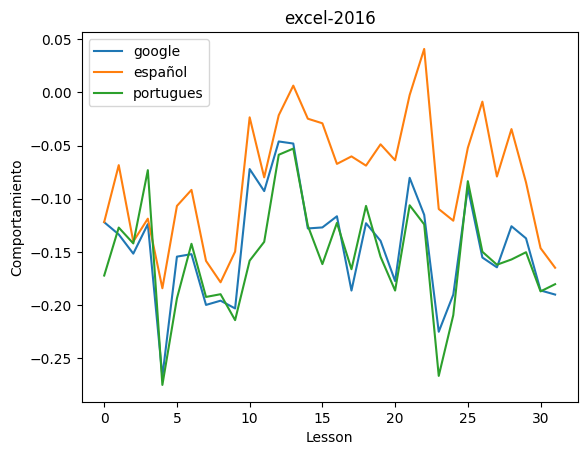

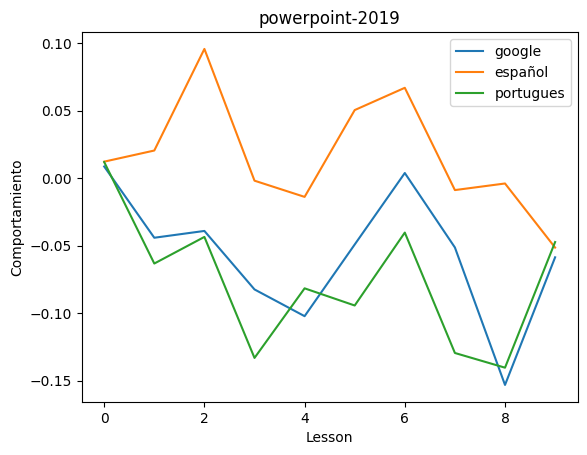

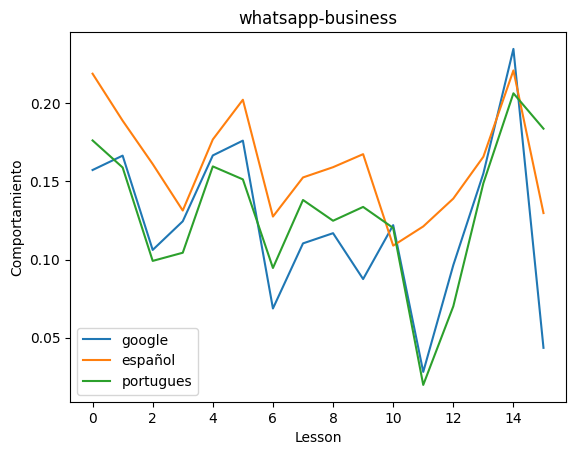

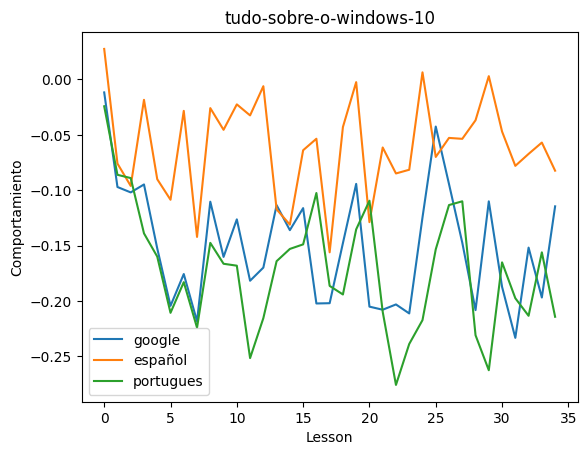

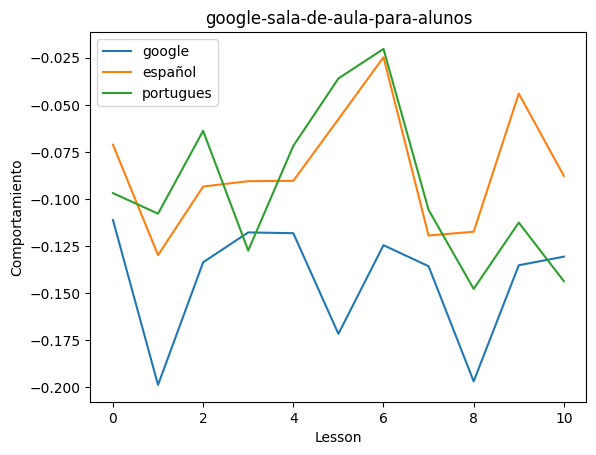

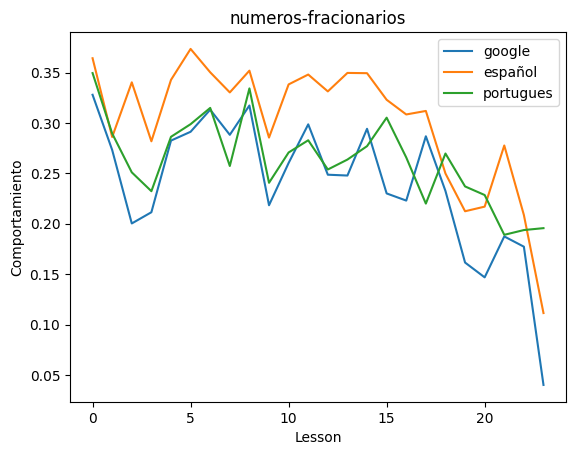

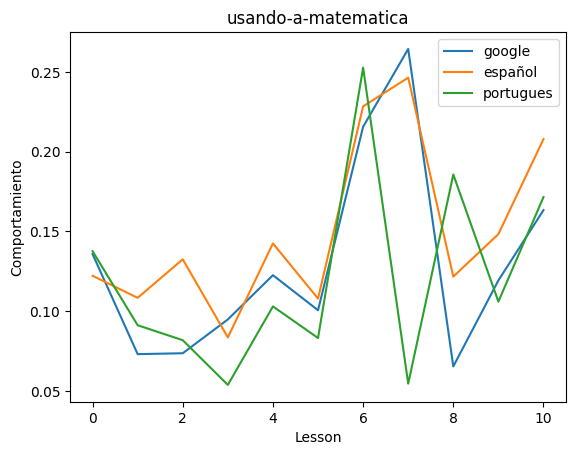

In [46]:
import matplotlib.pyplot as plt

for i in range(0,7):
    if len(courses[i]['es'])>len(courses[i]['pt']):
        x = [i for i in range(len(courses[i]['pt']))]
    else:
        x = [i for i in range(len(courses[i]['es']))]
    es = [i.mean() for i in courses[i]['es'][:len(x)]]
    pt = [i.mean() for i in courses[i]['pt'][:len(x)]]
    google = [i.mean() for i in courses[i]['google'][:len(x)]]

    fig, ax = plt.subplots()
    ax.set_title(courses[i]['name-es'])
    # Graficar las dos listas
    ax.plot(x, google, label='google')
    ax.plot(x, es, label='español')
    ax.plot(x, pt, label='portugues')
    # ax.plot(x,google, label='google')

    # Agregar leyenda y etiquetas de los ejes
    ax.legend()
    ax.set_xlabel('Lesson')
    ax.set_ylabel('Comportamiento')

    # Mostrar la gráfica
    plt.show()

## Comparaciones intracluster

In [ ]:
new_dict_windows10 = retrieve_lessons_text(db['lesson'], find_courses_by_name(collection_tutorials,('tudo-sobre-o-windows-10', 'como-usar-windows-10')))
new_dict_googleClassroom = retrieve_lessons_text(db['lesson'], find_courses_by_name(collection_tutorials,('google-sala-de-aula-para-alunos', 'google-classroom-para-estudiantes')))
new_dict_fraccionarios = retrieve_lessons_text(db['lesson'], find_courses_by_name(collection_tutorials,('numeros-fracionarios', 'fraccionarios')))
new_dict_matematica = retrieve_lessons_text(db['lesson'], find_courses_by_name(collection_tutorials,('usando-a-matematica', 'aplicaciones-de-la-matematica')))
new_dict_excel = retrieve_lessons_text(db['lesson'], find_courses_by_name(collection_tutorials, ('excel-2016',)))
new_dict_powerpoint = retrieve_lessons_text(db['lesson'], find_courses_by_name(collection_tutorials,('powerpoint-2019',)))
new_dict_whatsapp = retrieve_lessons_text(db['lesson'], find_courses_by_name(collection_tutorials,('whatsapp-business',)))

Found 1 tutorials for course tudo-sobre-o-windows-10 

Found 1 tutorials for course como-usar-windows-10 

Found 1 tutorials for course google-sala-de-aula-para-alunos 

Found 1 tutorials for course google-classroom-para-estudiantes 

Found 1 tutorials for course numeros-fracionarios 

Found 1 tutorials for course fraccionarios 

Found 1 tutorials for course usando-a-matematica 

Found 1 tutorials for course aplicaciones-de-la-matematica 

Found 2 tutorials for course excel-2016 

Found 2 tutorials for course powerpoint-2019 

Found 2 tutorials for course whatsapp-business 



In [ ]:
google_translations_windows10 = get_google_translations_from_txt('C:/Users/Usuario/Desktop/monitoria/analisis_traducciones/data/translate', "tudo-sobre-o-windows-10", new_dict_windows10)
google_translations_googleClassroom = get_google_translations_from_txt('C:/Users/Usuario/Desktop/monitoria/analisis_traducciones/data/translate', "google-sala-de-aula-para-alunos", new_dict_googleClassroom)
google_translations_fraccionarios = get_google_translations_from_txt('C:/Users/Usuario/Desktop/monitoria/analisis_traducciones/data/translate', "numeros-fracionarios", new_dict_fraccionarios)
google_translations_matematica = get_google_translations_from_txt('C:/Users/Usuario/Desktop/monitoria/analisis_traducciones/data/translate', "usando-a-matematica", new_dict_matematica)
google_translations_excel = get_google_translations_from_txt('C:/Users/Usuario/Desktop/monitoria/analisis_traducciones/data/translate', "excel-2016", new_dict_excel)
google_translations_powerpoint = get_google_translations_from_txt('C:/Users/Usuario/Desktop/monitoria/analisis_traducciones/data/translate', "powerpoint-2019", new_dict_powerpoint)
google_translations_whatsapp = get_google_translations_from_txt('C:/Users/Usuario/Desktop/monitoria/analisis_traducciones/data/translate', "whatsapp-business", new_dict_whatsapp)

In [ ]:
encoded_lessons_windows10 = encode_course_by_lesson(new_dict_windows10, "tudo-sobre-o-windows-10", "multi-qa-distilbert-cos-v1", google_translations_windows10)
encoded_lessons_googleClassroom = encode_course_by_lesson(new_dict_googleClassroom, "google-sala-de-aula-para-alunos", "multi-qa-distilbert-cos-v1", google_translations_googleClassroom)
encoded_lessons_fraccionarios = encode_course_by_lesson(new_dict_fraccionarios, "numeros-fracionarios", "multi-qa-distilbert-cos-v1", google_translations_fraccionarios)
encoded_lessons_matematica = encode_course_by_lesson(new_dict_matematica, "usando-a-matematica", "multi-qa-distilbert-cos-v1", google_translations_matematica)
encoded_lessons_excel = encode_course_by_lesson(new_dict_excel, "excel-2016", "multi-qa-distilbert-cos-v1", google_translations_excel)
encoded_lessons_powerpoint = encode_course_by_lesson(new_dict_powerpoint, "powerpoint-2019", "multi-qa-distilbert-cos-v1", google_translations_powerpoint)
encoded_lessons_whatsapp = encode_course_by_lesson(new_dict_whatsapp, "whatsapp-business", "multi-qa-distilbert-cos-v1", google_translations_whatsapp)

In [ ]:
pca_encoded_windows10 = pca_encodings_by_lesson(encoded_lessons_windows10, "tudo-sobre-o-windows-10")
pca_encoded_googleClassroom = pca_encodings_by_lesson(encoded_lessons_googleClassroom, "google-sala-de-aula-para-alunos")
pca_encoded_fraccionarios = pca_encodings_by_lesson(encoded_lessons_fraccionarios, "numeros-fracionarios")
pca_encoded_matematica = pca_encodings_by_lesson(encoded_lessons_matematica, "usando-a-matematica")
pca_encoded_excel = pca_encodings_by_lesson(encoded_lessons_excel, "excel-2016")
pca_encoded_powerpoint = pca_encodings_by_lesson(encoded_lessons_powerpoint, "powerpoint-2019")
pca_encoded_whatsapp = pca_encodings_by_lesson(encoded_lessons_whatsapp, "whatsapp-business")

In [ ]:
intracluster_pairwise_distances_windows10 = calculate_intracluster_pairwise_distances(encoded_lessons_windows10, "tudo-sobre-o-windows-10")
intracluster_pairwise_distances_googleClassroom = calculate_intracluster_pairwise_distances(encoded_lessons_googleClassroom, "google-sala-de-aula-para-alunos")
intracluster_pairwise_distances_fraccionarios = calculate_intracluster_pairwise_distances(encoded_lessons_fraccionarios, "numeros-fracionarios")
intracluster_pairwise_distances_matematica = calculate_intracluster_pairwise_distances(encoded_lessons_matematica, "usando-a-matematica")
intracluster_pairwise_distances_excel = calculate_intracluster_pairwise_distances(encoded_lessons_excel, "excel-2016")
intracluster_pairwise_distances_powerpoint = calculate_intracluster_pairwise_distances(encoded_lessons_powerpoint, "powerpoint-2019")
intracluster_pairwise_distances_whatsapp = calculate_intracluster_pairwise_distances(encoded_lessons_whatsapp, "whatsapp-business")


In [ ]:
intracluster_pairwise_distances = [intracluster_pairwise_distances_windows10,
                   intracluster_pairwise_distances_googleClassroom,
                   intracluster_pairwise_distances_fraccionarios,
                   intracluster_pairwise_distances_matematica,
                   intracluster_pairwise_distances_excel,
                   intracluster_pairwise_distances_powerpoint,
                   intracluster_pairwise_distances_whatsapp]
courses_list=["tudo-sobre-o-windows-10",
              "google-sala-de-aula-para-alunos",
              "numeros-fracionarios",
              "usando-a-matematica",
              "excel-2016",
              "powerpoint-2019",
              "whatsapp-business"]

In [ ]:
cont = 0
for i in intracluster_pairwise_distances:
    i['es'].mean().plot()
    i['pt'].mean().plot()
    i['google'].mean().plot()
    plt.title(courses_list[cont])
    plt.legend(['es', 'pt', 'google'])
    plt.show()
    cont += 1



NameError: name 'intracluster_pairwise_distances' is not defined

## Compoaraciones InterCluster

In [ ]:
intercluster_distances_windows10 = calculate_intercluster_pairwise_distances(encoded_lessons_windows10, 'tudo-sobre-o-windows-10')
intercluster_distances_googleClassroom = calculate_intercluster_pairwise_distances(encoded_lessons_googleClassroom, 'google-sala-de-aula-para-alunos')
intercluster_distances_fraccionarios = calculate_intercluster_pairwise_distances(encoded_lessons_fraccionarios, 'numeros-fracionarios')
intercluster_distances_matematica = calculate_intercluster_pairwise_distances(encoded_lessons_matematica, 'usando-a-matematica')
intercluster_distances_excel = calculate_intercluster_pairwise_distances(encoded_lessons_excel, 'excel-2016')
intercluster_distances_powerpoint = calculate_intercluster_pairwise_distances(encoded_lessons_powerpoint, 'powerpoint-2019')
intercluster_distances_whatsapp = calculate_intercluster_pairwise_distances(encoded_lessons_whatsapp, 'whatsapp-business')

In [ ]:
intercluster_pairwise_distances = [intercluster_distances_windows10,
                   intercluster_distances_googleClassroom,
                   intercluster_distances_fraccionarios,
                   intercluster_distances_matematica,
                   intercluster_distances_excel,
                   intercluster_distances_powerpoint,
                   intercluster_distances_whatsapp]


['ptes', 'ptgoogle', 'esgoogle']


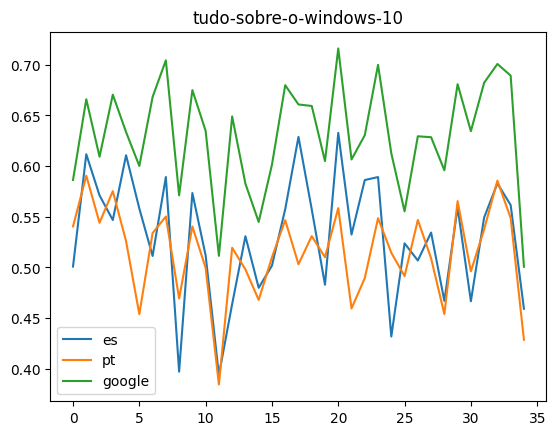

['ptes', 'ptgoogle', 'esgoogle']


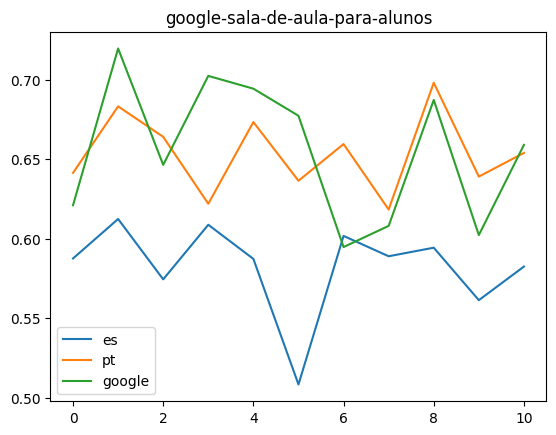

['ptes', 'ptgoogle', 'esgoogle']


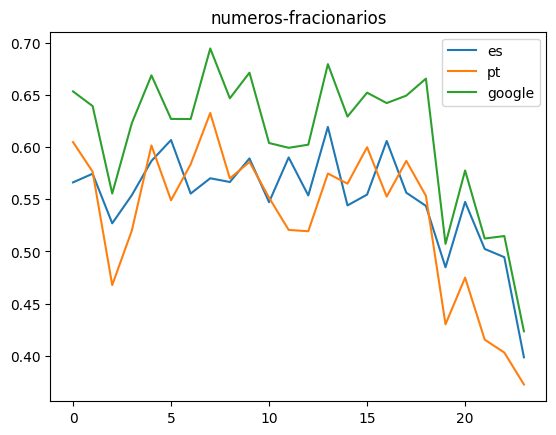

['ptes', 'ptgoogle', 'esgoogle']


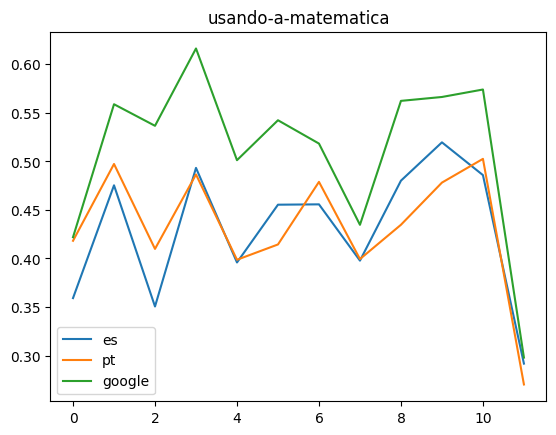

['espt', 'esgoogle', 'ptgoogle']


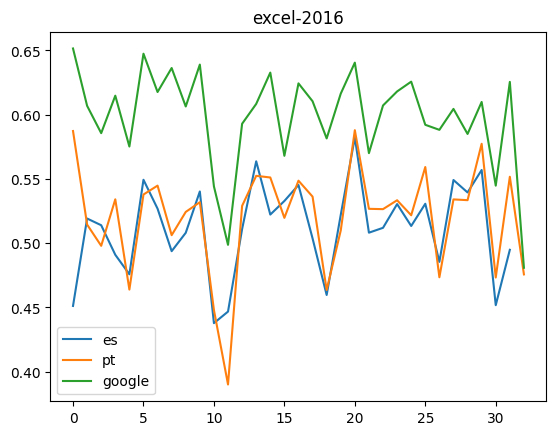

['espt', 'esgoogle', 'ptgoogle']


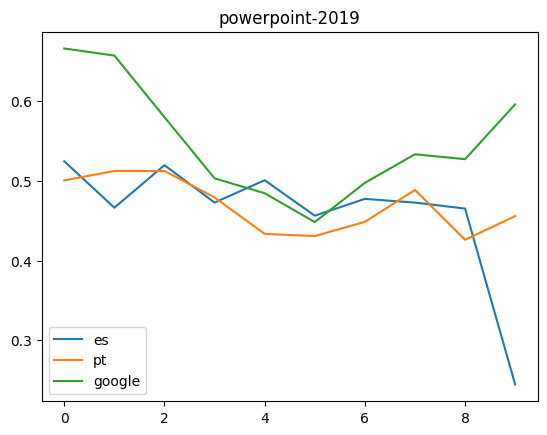

['espt', 'esgoogle', 'ptgoogle']


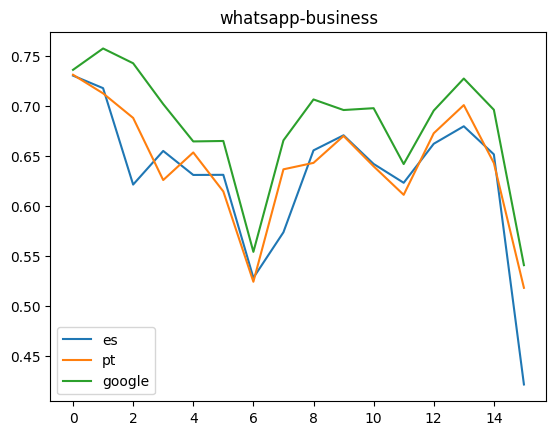

In [ ]:
cont = 0
for i in intercluster_pairwise_distances:
    print(list(i.keys()))
    if 'espt' in list(i.keys()):
        lang = 'espt'
    else:
        lang = 'ptes'
    i[lang].mean().plot()
    i['esgoogle'].mean().plot()
    i['ptgoogle'].mean().plot()
    
    plt.title(courses_list[cont])
    plt.legend(['es', 'pt', 'google'])
    plt.show()
    cont += 1